In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
train=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv")

In [3]:
train.dtypes

Id                      int64
income                  int64
age                     int64
experience              int64
married                object
house_ownership        object
car_ownership          object
profession             object
city                   object
state                  object
current_job_years       int64
current_house_years     int64
risk_flag               int64
dtype: object

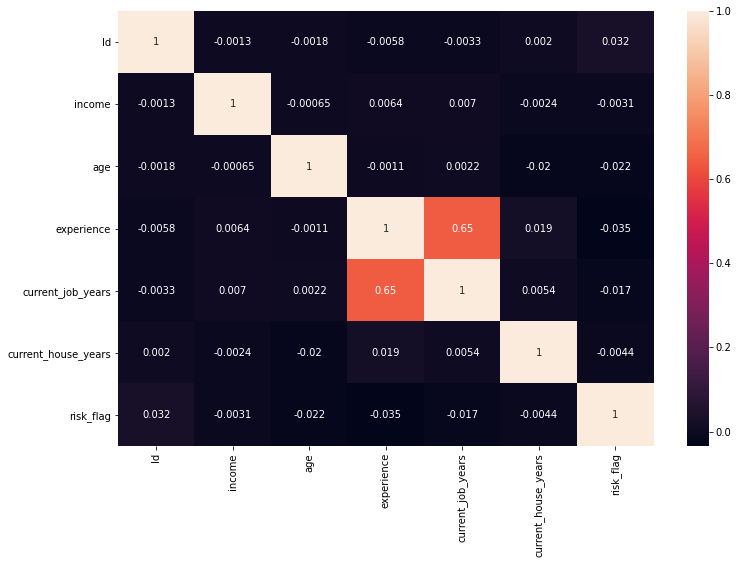

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True)

# Feature Enginnering

In [5]:
pip install prince

In [6]:
test=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Test Data.csv")
test.rename(columns={"id":"Id"},inplace=True)

y=train['risk_flag']
train_no_target=train.drop('risk_flag',axis=1)
loans=pd.concat([train_no_target,test],axis=0)

categorical_cols= ['car_ownership', 'profession', 'city','state','house_ownership','married','car_ownership']
numerical_cols =  ['income', 'age', 'experience', 'current_job_years','current_house_years']

In [7]:
loans

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,27996,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10
27996,27997,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14
27997,27998,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13
27998,27999,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14


In [8]:
print(categorical_cols,numerical_cols)

['car_ownership', 'profession', 'city', 'state', 'house_ownership', 'married', 'car_ownership'] ['income', 'age', 'experience', 'current_job_years', 'current_house_years']


In [9]:
import prince
mca = prince.MCA(n_components=2,random_state=42)
mca_features=mca.fit_transform(loans[categorical_cols])

In [10]:
mca1=mca_features[0]
mca2=mca_features[1]

In [11]:
train_no_target.loc[:,'MCA1'] = mca1[:len(train_no_target)]
test.loc[:,'MCA1']= mca1[len(train_no_target):]

# train_no_target.loc[:,'MCA2'] = mca2[:len(train_no_target)]
# test.loc[:,'MCA2']= mca2[len(train_no_target):]

In [12]:
from sklearn.decomposition import PCA

pca= PCA(n_components=2,random_state=202020).fit(loans[numerical_cols])
train_no_target.loc[:,'PCA1']= pca.transform(train_no_target[numerical_cols])[:,0]
test.loc[:,'PCA1']= pca.transform(test[numerical_cols])[:,0]

train_no_target.loc[:,'PCA2']= pca.transform(train_no_target[numerical_cols])[:,1]
test.loc[:,'PCA2']= pca.transform(test[numerical_cols])[:,1]

In [13]:
loans=pd.concat([train_no_target,test],axis=0)

In [14]:
loans.select_dtypes(include=["object"]).columns

Index(['married', 'house_ownership', 'car_ownership', 'profession', 'city',
       'state'],
      dtype='object')

In [15]:
def agg_groupby(df,primary_key,operations,agg_cols):
  return df.groupby(primary_key).agg(operations).reset_index().rename(columns=agg_cols)

def left_join(df1,df2,primary_key):
  return df1.merge(df2,how='left',on=primary_key)

def aggregation(df,primary_key,operation,cols):
  for c in cols:
    df=left_join(df,
                 agg_groupby(df,
                             [primary_key],
                             {c:operation},
                             {c:primary_key+"_"+operation+"_"+c}),
                 primary_key)
  return df

In [16]:
aggregation_columns = ['income', 'age', 'experience', 'current_job_years','current_house_years', 'PCA1','PCA2','MCA1']
operation=['mean','median','min','max','std']

In [17]:
for op in operation:
  loans=aggregation(loans,'state',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'city',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'profession',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'married',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'house_ownership',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'car_ownership',op,aggregation_columns)

In [18]:
loans=aggregation(loans,'profession','nunique',['state'])
loans=aggregation(loans,'profession','nunique',['city'])

loans=aggregation(loans,'car_ownership','nunique',['state'])
loans=aggregation(loans,'car_ownership','nunique',['city'])

loans=aggregation(loans,'house_ownership','nunique',['state'])
loans=aggregation(loans,'house_ownership','nunique',['city'])

loans=aggregation(loans,'married','nunique',['state'])
loans=aggregation(loans,'married','nunique',['city'])

loans=aggregation(loans,'married','nunique',['profession'])
loans=aggregation(loans,'house_ownership','nunique',['profession'])
loans=aggregation(loans,'car_ownership','nunique',['profession'])

In [19]:
loans.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,MCA1,PCA1,PCA2,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_PCA2,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_PCA2,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_current_house_years,state_min_PCA1,state_min_PCA2,state_min_MCA1,state_max_income,...,car_ownership_median_current_job_years,car_ownership_median_current_house_years,car_ownership_median_PCA1,car_ownership_median_PCA2,car_ownership_median_MCA1,car_ownership_min_income,car_ownership_min_age,car_ownership_min_experience,car_ownership_min_current_job_years,car_ownership_min_current_house_years,car_ownership_min_PCA1,car_ownership_min_PCA2,car_ownership_min_MCA1,car_ownership_max_income,car_ownership_max_age,car_ownership_max_experience,car_ownership_max_current_job_years,car_ownership_max_current_house_years,car_ownership_max_PCA1,car_ownership_max_PCA2,car_ownership_max_MCA1,car_ownership_std_income,car_ownership_std_age,car_ownership_std_experience,car_ownership_std_current_job_years,car_ownership_std_current_house_years,car_ownership_std_PCA1,car_ownership_std_PCA2,car_ownership_std_MCA1,profession_nunique_state,profession_nunique_city,car_ownership_nunique_state,car_ownership_nunique_city,house_ownership_nunique_state,house_ownership_nunique_city,married_nunique_state,married_nunique_city,married_nunique_profession,house_ownership_nunique_profession,car_ownership_nunique_profession
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0.481663,-3.696526e+06,-26.983843,4.888681e+06,49.579096,10.543407,6.576406,12.011188,-111680.589809,-0.385460,0.176036,4735088,49.0,11,6,12,-265273.264218,-0.954734,0.393431,13629,21,0,0,10,-4.986732e+06,-28.991892,-0.646091,9994932,...,6,12,21818.735782,0.031143,0.246460,10318,21,0,0,10,-4.990043e+06,-28.991892,-1.046713,9999814,79,20,14,14,4.999453e+06,29.062780,2.261622,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.377783,29,299,37,333,37,333,37,333,74,74,74
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0.203566,2.574155e+06,-9.952688,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.049744,0.173001,-0.186466,5194149,50.0,10,6,12,193787.735782,0.040715,0.026159,10318,21,0,0,10,-4.990043e+06,-28.990043,-0.986276,9987388,...,6,12,21818.735782,0.031143,0.246460,10318,21,0,0,10,-4.990043e+06,-28.991892,-1.046713,9999814,79,20,14,14,4.999453e+06,29.062780,2.261622,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.377783,29,299,37,333,37,333,37,333,74,74,74
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0.053889,-1.008546e+06,16.033857,5.153478e+06,50.800439,8.561373,5.919110,12.071014,153116.709759,0.836751,-0.141255,5421502,52.0,8,6,12,421140.735782,2.023758,0.077655,16212,21,0,0,10,-4.984149e+06,-28.991691,-0.906678,9987955,...,6,12,21818.735782,0.031143,0.246460,10318,21,0,0,10,-4.990043e+06,-28.991892,-1.046713,9999814,79,20,14,14,4.999453e+06,29.062780,2.261622,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.377783,28,297,37,333,37,333,37,333,74,74,74
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,0.327451,1.256090e+06,-8.960311,4.931571e+06,49.287296,11.217366,6.432401,12.014763,-68790.362703,-0.677208,0.904731,4739803,50.0,12,6,12,-260558.264218,0.052339,1.093114,13696,21,0,0,10,-4.986665e+06,-28.986481,0.108813,9991569,...,6,12,-60697.264218,0.030290,-0.667287,10310,21,0,0,10,-4.990051e+06,-28.991691,-1.862094,9999938,79,20,14,14,4.999577e+06,29.063654,1.446241,2.873480e+06,16.918784,6.017089,3.694749,1.405083,2.873480e+06,16.

# Remove columns with unique value 

In [20]:
counts=loans.nunique()
to_del = [i for i,v in enumerate(counts) if v == 1]

In [21]:
col_names_del=loans.nunique().index[to_del]
print(len(col_names_del))

51


In [22]:
loans.drop(col_names_del,axis=1,inplace=True)

In [23]:
loans.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,MCA1,PCA1,PCA2,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_PCA2,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_PCA2,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_PCA1,state_min_PCA2,state_min_MCA1,state_max_income,state_max_age,...,house_ownership_std_income,house_ownership_std_age,house_ownership_std_experience,house_ownership_std_current_job_years,house_ownership_std_current_house_years,house_ownership_std_PCA1,house_ownership_std_PCA2,house_ownership_std_MCA1,car_ownership_mean_income,car_ownership_mean_age,car_ownership_mean_experience,car_ownership_mean_current_job_years,car_ownership_mean_current_house_years,car_ownership_mean_PCA1,car_ownership_mean_PCA2,car_ownership_mean_MCA1,car_ownership_median_income,car_ownership_median_PCA1,car_ownership_median_PCA2,car_ownership_median_MCA1,car_ownership_min_income,car_ownership_min_PCA1,car_ownership_min_PCA2,car_ownership_min_MCA1,car_ownership_max_income,car_ownership_max_PCA1,car_ownership_max_PCA2,car_ownership_max_MCA1,car_ownership_std_income,car_ownership_std_age,car_ownership_std_experience,car_ownership_std_current_job_years,car_ownership_std_current_house_years,car_ownership_std_PCA1,car_ownership_std_PCA2,car_ownership_std_MCA1,profession_nunique_state,profession_nunique_city,house_ownership_nunique_state,house_ownership_nunique_city
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0.481663,-3.696526e+06,-26.983843,4.888681e+06,49.579096,10.543407,6.576406,12.011188,-111680.589809,-0.385460,0.176036,4735088,49.0,11,6,12,-265273.264218,-0.954734,0.393431,13629,21,0,0,-4.986732e+06,-28.991892,-0.646091,9994932,79,...,2.881848e+06,17.063339,6.006828,3.635123,1.395724,2.881848e+06,17.063418,0.548084,4.993240e+06,49.856000,10.057707,6.309286,11.997429,-7120.793015,-0.108177,0.263374,5022180,21818.735782,0.031143,0.246460,10318,-4.990043e+06,-28.991892,-1.046713,9999814,4.999453e+06,29.062780,2.261622,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.377783,29,299,37,333
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0.203566,2.574155e+06,-9.952688,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.049744,0.173001,-0.186466,5194149,50.0,10,6,12,193787.735782,0.040715,0.026159,10318,21,0,0,-4.990043e+06,-28.990043,-0.986276,9987388,79,...,2.881848e+06,17.063339,6.006828,3.635123,1.395724,2.881848e+06,17.063418,0.548084,4.993240e+06,49.856000,10.057707,6.309286,11.997429,-7120.793015,-0.108177,0.263374,5022180,21818.735782,0.031143,0.246460,10318,-4.990043e+06,-28.991892,-1.046713,9999814,4.999453e+06,29.062780,2.261622,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.377783,29,299,37,333
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0.053889,-1.008546e+06,16.033857,5.153478e+06,50.800439,8.561373,5.919110,12.071014,153116.709759,0.836751,-0.141255,5421502,52.0,8,6,12,421140.735782,2.023758,0.077655,16212,21,0,0,-4.984149e+06,-28.991691,-0.906678,9987955,79,...,2.881848e+06,17.063339,6.006828,3.635123,1.395724,2.881848e+06,17.063418,0.548084,4.993240e+06,49.856000,10.057707,6.309286,11.997429,-7120.793015,-0.108177,0.263374,5022180,21818.735782,0.031143,0.246460,10318,-4.990043e+06,-28.991892,-1.046713,9999814,4.999453e+06,29.062780,2.261622,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.377783,28,297,37,333
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,0.327451,1.256090e+06,-8.960311,4.931571e+06,49.287296,11.217366,6.432401,12.014763,-68790.362703,-0.677208,0.904731,

In [ ]:
# from sklearn.feature_selection import VarianceThreshold
# transform = VarianceThreshold(threshold=0.3)
# transform.fit_transform(loans[numerical_cols]).shape

(279987, 5)

# Preprocessing

In [24]:
train = loans[:len(train)]
test  = loans[len(train):]
print(train.shape,test.shape)

(252000, 215) (28000, 215)


## Oversampling

In [25]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(train,y)
X_over=pd.DataFrame(X_over,columns=train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
print(X_over.shape,y_over.shape)

(442008, 215) (442008,)


In [27]:
np.unique(y_over,return_counts=True)

(array([0, 1]), array([221004, 221004]))

## Over + Random 

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
x_train_knn=pd.get_dummies(data=train,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_train_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [ ]:
print(x_over.shape,y_over.shape)

(331506, 256) (331506,)


In [ ]:
np.unique(y_over,return_counts=True)

(array([0, 1]), array([221004, 110502]))

# SMOTE + under

In [ ]:
cate_features_index = np.where(train.dtypes == object)[0]
print(cate_features_index)

[4 5 6 7 8 9]


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
over = SMOTENC(sampling_strategy=0.1,categorical_features=cate_features_index)
under = RandomUnderSampler(sampling_strategy=0.5)

In [ ]:
x_over,y_over=over.fit_resample(train,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_over=pd.DataFrame(x_over,columns=train.columns)

In [ ]:
x_train_knn=pd.get_dummies(data=x_over,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_train_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [ ]:
np.unique(y_over,return_counts=True)

(array([0, 1]), array([221004, 110502]))

# Sampling with KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='distance')

In [29]:
x_train_knn=pd.get_dummies(data=X_over,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_train_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [58]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_knn,y_over,random_state=0,test_size=0.2,shuffle=True)

In [30]:
knn.fit(x_train_knn,y_over)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                     weights='distance')

In [60]:
pred=knn.predict(x_val)

0.9267153420904011


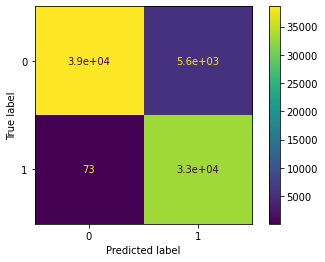

In [61]:
from sklearn.metrics import roc_auc_score,confusion_matrix,ConfusionMatrixDisplay
print(roc_auc_score(pred,y_val))
cm=confusion_matrix(y_pred=pred,y_true=y_val)
disp=ConfusionMatrixDisplay(cm,knn.classes_)
disp.plot()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(pred,y_val))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     38667
           1       1.00      0.86      0.92     38685

    accuracy                           0.93     77352
   macro avg       0.94      0.93      0.93     77352
weighted avg       0.94      0.93      0.93     77352



In [63]:
def threshold_pred(prob,thresh): 
  y_pred=[]
  for i in range(len(prob)):
    if prob[i][1]>=thresh:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return np.array(y_pred)

In [66]:
pred_pnt6=threshold_pred(knn.predict_proba(x_val),0.75)

0.9073697237436893


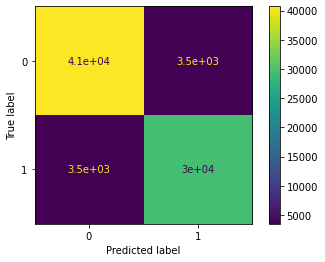

In [67]:
from sklearn.metrics import roc_auc_score,confusion_matrix,ConfusionMatrixDisplay
print(roc_auc_score(pred_pnt6,y_val))
cm=confusion_matrix(y_pred=pred_pnt6,y_true=y_val)
disp=ConfusionMatrixDisplay(cm,knn.classes_)
disp.plot()

In [68]:
from sklearn.metrics import classification_report
print(classification_report(pred_pnt6,y_val))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     44252
           1       0.89      0.89      0.89     33100

    accuracy                           0.91     77352
   macro avg       0.91      0.91      0.91     77352
weighted avg       0.91      0.91      0.91     77352



In [32]:
test_knn=pd.get_dummies(data=test,columns=["house_ownership","married","car_ownership"],drop_first=True)
test_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [33]:
test_knn.shape

(28000, 212)

In [34]:
pred_knn=knn.predict(test_knn)

In [35]:
result_pnt75=pd.DataFrame()
result_pnt75["id"]=test["Id"]
result_pnt75["risk_flag"]=pred_knn
print(result_pnt75.risk_flag.value_counts())

0    21082
1     6918
Name: risk_flag, dtype: int64


In [ ]:
result_pnt75.to_csv("pred_knn_MoreextraFeat_over.csv",index=False)

# KNN 

In [ ]:
x_train_knn=pd.get_dummies(data=X_over,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_train_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [ ]:
x_train_knn.head()

,income,age,experience,current_job_years,current_house_years,MCA1,PCA1,PCA2,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_PCA2,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_PCA2,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_current_house_years,state_min_PCA1,state_min_PCA2,state_min_MCA1,state_max_income,state_max_age,state_max_experience,state_max_current_job_years,state_max_current_house_years,state_max_PCA1,state_max_PCA2,state_max_MCA1,...,car_ownership_median_income,car_ownership_median_age,car_ownership_median_experience,car_ownership_median_current_job_years,car_ownership_median_current_house_years,car_ownership_median_PCA1,car_ownership_median_PCA2,car_ownership_median_MCA1,car_ownership_min_income,car_ownership_min_age,car_ownership_min_experience,car_ownership_min_current_job_years,car_ownership_min_current_house_years,car_ownership_min_PCA1,car_ownership_min_PCA2,car_ownership_min_MCA1,car_ownership_max_income,car_ownership_max_age,car_ownership_max_experience,car_ownership_max_current_job_years,car_ownership_max_current_house_years,car_ownership_max_PCA1,car_ownership_max_PCA2,car_ownership_max_MCA1,car_ownership_std_income,car_ownership_std_age,car_ownership_std_experience,car_ownership_std_current_job_years,car_ownership_std_current_house_years,car_ownership_std_PCA1,car_ownership_std_PCA2,car_ownership_std_MCA1,profession_nunique_state,profession_nunique_city,married_nunique_profession,house_ownership_nunique_profession,house_ownership_owned,house_ownership_rented,married_single,car_ownership_yes
0,1303835,23,3,3,13,0.309445,-3.69653e+06,-26.9838,4.88868e+06,49.5791,10.5434,6.57641,12.0112,-111681,-0.38546,0.28505,4735088,49,11,6,12,-265273,-0.954734,0.29803,13629,21,0,0,10,-4.98673e+06,-28.9919,0.0748413,9994932,79,20,14,14,4.99457e+06,29.0602,0.49547,...,5022180,50,10,6,12,21818.7,0.0311432,-0.0753326,10318,21,0,0,10,-4.99004e+06,-28.9919,-2.73112,9999814,79,20,14,14,4.99945e+06,29.0628,5.20636,2.87848e+06,17.1344,5.99963,3.62574,1.39624,2.87848e+06,17.1344,0.717207,29,299,74,74,0,1,1,0
1,7574516,40,10,9,13,0.0992672,2.57415e+06,-9.95269,5.01746e+06,50.1369,10.0129,6.4055,11.936,17095,0.173001,-0.0257652,5194149,50,10,6,12,193788,0.0407147,-0.020857,10318,21,0,0,10,-4.99004e+06,-28.99,-0.238313,9987388,79,20,14,14,4.98703e+06,29.0584,0.25871,...,5022180,50,10,6,12,21818.7,0.0311432,-0.0753326,10318,21,0,0,10,-4.99004e+06,-28.9919,-2.73112,9999814,79,20,14,14,4.99945e+06,29.0628,5.20636,2.87848e+06,17.1344,5.99963,3.62574,1.39624,2.87848e+06,17.1344,0.717207,29,299,74,74,0,1,1,0
2,3991815,66,4,4,10,-0.193964,-1.00855e+06,16.0339,5.15348e+06,50.8004,8.56137,5.91911,12.071,153117,0.836751,-0.189365,5421502,52,8,6,12,421141,2.02376,-0.193439,16212,21,0,0,10,-4.98415e+06,-28.9917,-0.404534,9987955,79,20,14,14,4.98759e+06,29.0572,0.0846877,...,5022180,50,10,6,12,21818.7,0.0311432,-0.0753326,10318,21,0,0,10,-4.99004e+06,-28.9919,-2.73112,9999814,79,20,14,14,4.99945e+06,29.0628,5.20636,2.87848e+06,17.1344,5.99963,3.62574,1.39624,2.87848e+06,17.1344,0.717207,28,297,74,74,0,1,0,0
3,6256451,41,2,2,12,-0.912883,1.25609e+06,-8.96031,4.93157e+06,49.2873,11.2174,6.4324,12.0148,-68790.4,-0.677208,-1.02498,4739803,50,12,6,12,-260558,0.0523394,-1.01176,13696,21,0,0,10,-4.98667e+06,-28.9865,-1.2237,9991569,79,20,14,14,4.99121e+06,29.0589,-0.756253,...,4939664,50,10,6,12,-60697.3,0.03029,-0.0920367,10310,21,0,0,10,-4.99005e+06,-28.9917,-2.71092,9999938,79,20,14,14,4.99958e+06,29.0637,5.19331,2.87348e+06,16.9188,6.01709,3.69475,1.40508,2.87348e+06,16.9187,0.698244,29,299,74,74,0,1,1,1
4,5768871,47,11,3,14,0.789893,768510,-2.96608,5.04438e+06,50.1046,10.3934,6.55439,11.9858,44021.1,0.140802,0.739489,5074244,51,10,6,12,73882.7,1.01823,0.741247,11735,21,0

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_knn,y_over,random_state=0,test_size=0.2,shuffle=True)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,plot_confusion_matrix
grid_params={
    'n_neighbors':[3,5,11,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
gs=GridSearchCV(KNeighborsClassifier(),grid_params,verbose=2,cv=3)

gs_results=gs.fit(x_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=  47.8s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.4s remaining:    0.0s


[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=  48.1s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total=  49.5s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total=  45.6s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total=  45.7s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total=  45.4s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=5, weights=uniform, total=  51.9s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=5, weights=uniform, total=  52.2s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 73.4min finished


In [ ]:
gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='distance')

In [ ]:
y_pred_val=gs_results.predict(x_val)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

In [ ]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     44217
           1       0.81      0.98      0.89     22085

    accuracy                           0.92     66302
   macro avg       0.90      0.93      0.91     66302
weighted avg       0.93      0.92      0.92     66302



In [ ]:
auc_test = roc_auc_score(y_val, y_pred_val)
print('ROC AUC test: %f' % auc_test)

ROC AUC test: 0.933252


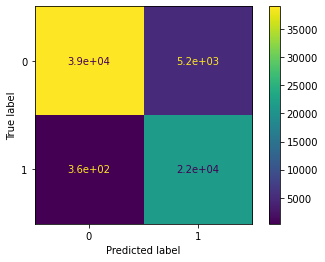

In [ ]:
cm=confusion_matrix(y_pred=y_pred_val,y_true=y_val)
disp=ConfusionMatrixDisplay(cm,gs_results.classes_)
disp.plot()

In [ ]:
prob=gs_results.predict_proba(x_val)

In [ ]:
import pickle
pickle.dump(gs_results, open("knn_extraFeatures_noID_over_pnt5.sav", 'wb'))

In [ ]:
def threshold_pred(prob,thresh): 
  y_pred=[]
  for i in range(len(prob)):
    if prob[i][1]>=thresh:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return np.array(y_pred)

In [ ]:
y_pred_knn_pnt8=threshold_pred(prob,0.75)
y_pred_knn_pnt8=np.array(y_pred_knn_pnt8)

In [ ]:
print(classification_report(y_val,y_pred_knn_pnt8))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     44399
           1       0.90      0.97      0.93     44003

    accuracy                           0.93     88402
   macro avg       0.94      0.93      0.93     88402
weighted avg       0.94      0.93      0.93     88402



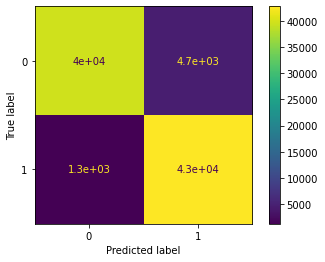

In [ ]:
cm=confusion_matrix(y_pred=y_pred_knn_pnt8,y_true=y_val)
disp=ConfusionMatrixDisplay(cm,gs_results.classes_)
disp.plot()

In [ ]:
#y_pred_val=gs_results.predict(x_val)
auc_test = roc_auc_score(y_val, y_pred_knn_pnt8)
print('ROC AUC test: %f' % auc_test)

ROC AUC test: 0.932933


In [ ]:
test_knn=pd.get_dummies(data=test,columns=["house_ownership","married","car_ownership"],drop_first=True)
test_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [ ]:
pred_test=gs_results.predict(test_knn)

In [ ]:
result_pnt75=pd.DataFrame()
result_pnt75["id"]=test["Id"]
result_pnt75["risk_flag"]=pred_test
print(result_pnt75.risk_flag.value_counts())

0    22282
1     5718
Name: risk_flag, dtype: int64


In [ ]:
result_pnt75.to_csv("knn_extraFeat_noID_over0.5.csv",index=False)

In [ ]:
pred_knn=gs_results.predict(test_knn)
result=pd.DataFrame()
result["id"]=test["Id"]
result["risk_flag"]=pred_knn
print(result.risk_flag.value_counts())

0    21111
1     6889
Name: risk_flag, dtype: int64


In [ ]:
result.to_csv("knn_extraFeat_noID.csv",index=False)

# Catboost 

In [ ]:
train_id = loans.Id[:len(train)]
test_id  = loans.Id[len(train):]
loans.drop("Id",axis=1,inplace=True)

In [ ]:
train = loans[:len(train)]
test  = loans[len(train):]
print(train.shape,test.shape)

(252000, 258) (28000, 258)


In [ ]:
categorical_cols= ['married', 'house_ownership', 'car_ownership', 'profession', 'city','state']
for cols in categorical_cols:
    train[cols] = train[cols].astype(str)
    test[cols]  = test[cols].astype(str)

cate_features_index = np.where(train.dtypes == object)[0]
print(cate_features_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[3 4 5 6 7 8]


In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='all')
X_over, y_over = oversample.fit_resample(train,y)
X_over=pd.DataFrame(X_over,columns=train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(np.unique(y_over,return_counts=True))

(array([0, 1]), array([221004, 221004]))


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_over,y_over,random_state=0,test_size=0.2,shuffle=True)

In [ ]:
cate_features_index

array([3, 4, 5, 6, 7, 8])

In [ ]:
pip install catboost

     |████████████████████████████████| 67.3MB 233kB/s 


In [ ]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier(n_estimators=2000,random_state=0)
cat.fit(x_train,y_train,cat_features=cate_features_index,eval_set=(x_val,y_val))

Learning rate set to 0.099872
0:	learn: 0.6113469	test: 0.6075766	best: 0.6075766 (0)	total: 763ms	remaining: 25m 25s
1:	learn: 0.5565647	test: 0.5496203	best: 0.5496203 (1)	total: 1.46s	remaining: 24m 14s
2:	learn: 0.5112393	test: 0.5013612	best: 0.5013612 (2)	total: 1.99s	remaining: 22m 6s
3:	learn: 0.4787368	test: 0.4669205	best: 0.4669205 (3)	total: 2.68s	remaining: 22m 15s
4:	learn: 0.4477338	test: 0.4338979	best: 0.4338979 (4)	total: 3.26s	remaining: 21m 42s
5:	learn: 0.4289305	test: 0.4137877	best: 0.4137877 (5)	total: 3.78s	remaining: 20m 56s
6:	learn: 0.4114366	test: 0.3952259	best: 0.3952259 (6)	total: 4.3s	remaining: 20m 25s
7:	learn: 0.3963931	test: 0.3776103	best: 0.3776103 (7)	total: 4.76s	remaining: 19m 46s
8:	learn: 0.3872749	test: 0.3675027	best: 0.3675027 (8)	total: 5.25s	remaining: 19m 21s
9:	learn: 0.3805713	test: 0.3604710	best: 0.3604710 (9)	total: 5.78s	remaining: 19m 9s
10:	learn: 0.3744380	test: 0.3538896	best: 0.3538896 (10)	total: 6.22s	remaining: 18m 45s
11:

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred_val=cat.predict(x_val)
auc_test = roc_auc_score(y_val, y_pred_val)
print('ROC AUC test: %f' % auc_test)

ROC AUC test: 0.949725


In [ ]:
def threshold_pred(prob,thresh): 
  y_pred=[]
  for i in range(len(prob)):
    if prob[i][1]>=thresh:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return np.array(y_pred)

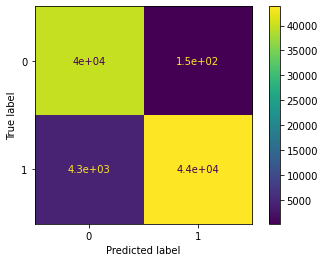

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(y_pred_val,y_val)
disp=ConfusionMatrixDisplay(cm,cat.classes_)
disp.plot()

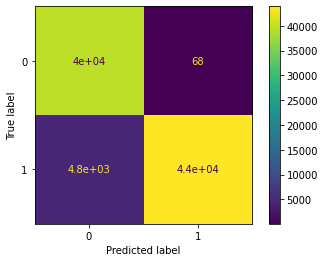

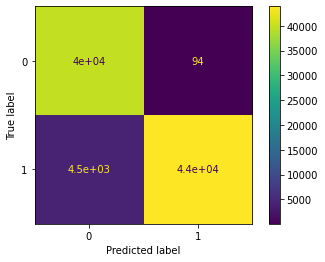

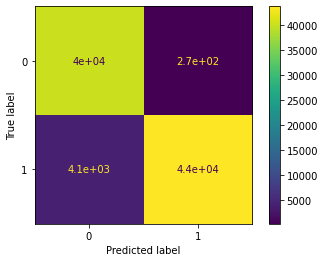

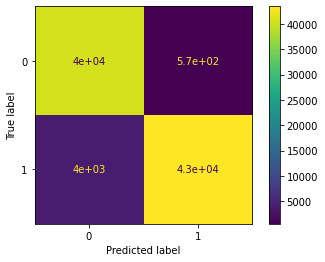

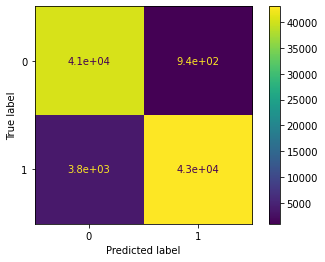

In [ ]:
th=[0.3,0.4,0.6,0.7,0.75]
cat_prob=cat.predict_proba(x_val)
for t in th:
  cm=confusion_matrix(threshold_pred(cat_prob,t),y_val)
  disp=ConfusionMatrixDisplay(cm,cat.classes_)
  disp.plot()

In [ ]:
pred=cat.predict(test)
test_prob=cat.predict_proba(test)
pred_pnt7=threshold_pred(test_prob,0.7)
print(np.unique(pred,return_counts=True))
print(np.unique(pred_pnt4,return_counts=True))

(array([0, 1]), array([17182, 10818]))
(array([0, 1]), array([22636,  5364]))


In [ ]:
result=pd.DataFrame()
result["id"]=test_id
result["risk_flag"]=pred_pnt7
print(result.risk_flag.value_counts())

0    22636
1     5364
Name: risk_flag, dtype: int64


In [ ]:
result.to_csv("cat_extraFeat_noID_thresh-PNT7.csv",index=False)

In [ ]:
import pickle
pickle.dump(cat, open("catboost_extraFeat_noID.sav", 'wb'))